In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly
import plotly.subplots as sp
import os
from cloudvolume import CloudVolume as cv
from caveclient import CAVEclient
import meshparty

vol =cv('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', agglomerate=True, use_https=True)
client = CAVEclient('zheng_ca3')

isotropy = [5,5,2]
d_from_nucleus = 20000   # [nm]

In [4]:
PC_nucleus_file_path = './data/pyramidal_cells_with_depth.csv'
IN_file_path = './data/inhibitory_cells_240821.csv'

columns_to_load1 = ['Index','nuclei_id', 'x', 'y', 'z','Pyramidal']
table1 = pd.read_csv(PC_nucleus_file_path, usecols = columns_to_load1)
PC_table = table1[table1['Pyramidal'] == 'Yes']
nuclei_coord_in_vol = PC_table[['x','y','z']].to_numpy()

table3 = pd.read_csv(IN_file_path, dtype=str)
IN_table = table3[table3['inhibitory'] == 'Yes']
nuclei_coord_in_vol3 = IN_table[['x','y','z']].to_numpy()
nuclei_coord_in_vol3 = nuclei_coord_in_vol3.astype(int)
orphan_table = table3[table3['inhibitory'] == 'orphan']

latest_roots_PC = []
cell_IDs = []
idx_empty_nuclei_center = []
print('Getting latest roots for PC...')  
for i in range(0, len(nuclei_coord_in_vol)):
    cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1], nuclei_coord_in_vol[i,2]].squeeze()])
    cell_IDs.append(cell_ID[0])
    if cell_ID[0] == 0:
        idx_empty_nuclei_center.append(i)
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0]+150, nuclei_coord_in_vol[i,1], nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0]-150, nuclei_coord_in_vol[i,1], nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]+150, nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]-150, nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        print("Failed to find neuron segment ID using nuclei center")
    if i % 100 == 0:
        print(i)
    if client.chunkedgraph.is_latest_roots(cell_ID[0]):
        latest_roots_PC.append(cell_ID[0])
    else:
        latest_roots_PC.append(client.chunkedgraph.suggest_latest_roots(cell_ID[0]))
    

Getting latest roots for PC...
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [14]:
i=0
latest_roots_PC=[]
latest_roots_PC.append(client.chunkedgraph.suggest_latest_roots(648518346438304146))


In [12]:
import pcg_skel
import meshparty

for i in range(0, len(latest_roots_PC)):
    nuclei_coord = nuclei_coord_in_vol[i,:].copy()
    nuclei_coord *= [18,18,45]
    try:
        skel = pcg_skel.pcg_skeleton(root_id=latest_roots_PC[i], client=client, root_point=nuclei_coord)
        meshparty.skeleton_io.export_to_swc(skel, './skel/sk_' + str(i) +'.swc', node_labels=None, radius=None, 
                                        header=None, xyz_scaling=1000, resample_spacing=1000, interp_kind='linear', 
                                        tip_length_ratio=0.25, avoid_root=True)
    except Exception as e:
        print('skipping iteration ' + str(i))
        continue

skipping iteration 1411


In [9]:
import navis
for i in range(0, len(latest_roots_PC)):
    mesh = vol.mesh.get(latest_roots_PC[0])[latest_roots_PC[0]]   
    m = navis.MeshNeuron((mesh.vertices, mesh.faces), name=latest_roots_PC[0], id=latest_roots_PC[0], units='nanometers')
    m2 = navis.simplify_mesh(m, F=1/3)
    navis.write_mesh(m2, '../mesh/pc_nuclei_index_'+i+'.obj')

    

type            navis.MeshNeuron
name          648518346447714663
id            648518346447714663
units                1 nanometer
n_vertices               1087563
n_faces                  2158128
dtype: object
type            navis.MeshNeuron
name          648518346447714663
id            648518346447714663
units                1 nanometer
n_vertices                368068
n_faces                   717572
dtype: object


In [10]:
import time
start_time = time.time()
sk=m2.skeletonize() # takes about 6 min
print(sk)
end_time = time.time()
print(end_time - start_time) # seconds

type              navis.TreeNeuron
name            648518346447714663
id              648518346447714663
n_nodes                      37838
n_connectors                  None
n_branches                    7333
n_leafs                       5854
cable_length       10360841.859721
soma                          None
units                  1 nanometer
dtype: object


NameError: name 'start_time' is not defined

In [11]:
print(end_time - start_tile)

357.72841024398804


In [12]:
navis.write_mesh(m2, '../neuron.obj')


/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_14811/1815630993.py:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,2], c=(0.7,0.7,0.7), s=1, alpha=.2)


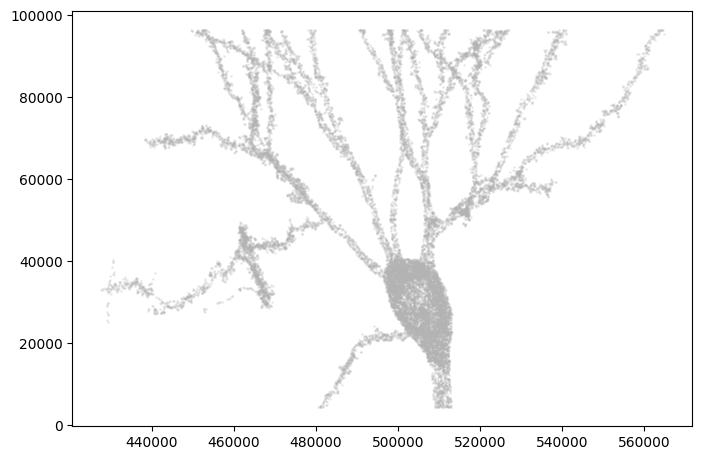

In [11]:
f, ax = plt.subplots(figsize=(8,8))
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,2], c=(0.7,0.7,0.7), s=1, alpha=.2)
#ax.scatter(nuclei_coord[0]//5, nuclei_coord[2]//2, c=(0,0.6,1), s=10, alpha=1)
#ax.plot(mesh.vertices[syn_to_syn_path,0], mesh.vertices[syn_to_syn_path,2], c=(1,0.2,0.2), linewidth=4)
#ax.scatter(syn_xyz[:,0], syn_xyz[:,2], c='b', s=10)
ax.set_aspect('equal')